In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

In [ ]:
# Lettura del dataset pulito
df = pd.read_csv("AirDelay_clean.csv")

In [ ]:
# Definizione delle colonne target (cause di ritardo)
targets = ["carrier_delay", "weather_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
# Definizione delle feature base utilizzate per la previsione
features = ["month", "arr_flights", "arr_del15", "arr_cancelled", "arr_diverted"]

In [ ]:
# Separazione tra feature (X) e target (Y)
X = df[features]
Y = df[targets]

In [ ]:
# Divisione train/test set (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error
# Modellazione XGBoost
results_xgb = {}

for target in targets:
    model = xgb.XGBRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, Y_train[target])  # Addestramento del modello
    y_pred = model.predict(X_test)       # Predizione sul test set
    
    # Calcolo MSE e RMSE
    mse = mean_squared_error(Y_test[target], y_pred)
    rmse = np.sqrt(mse)
    results_xgb[target] = {"MSE": mse, "RMSE": rmse}  # Salvataggio risultati

In [ ]:
# Modellazione LightGBM

results_lgb = {}

for target in targets:
    model = lgb.LGBMRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, Y_train[target])
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(Y_test[target], y_pred)
    rmse = np.sqrt(mse)
    results_lgb[target] = {"MSE": mse, "RMSE": rmse}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 80408, number of used features: 5
[LightGBM] [Info] Start training from score 111.102515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 80408, number of used features: 5
[LightGBM] [Info] Start training from score 15.103410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Scaling dei valori MSE per confronto

def scale_mse(results):
    """
    Scala i valori di MSE tra 0 e 1 usando MinMaxScaler
    e aggiunge la colonna 'MSE_scaled' al dizionario dei risultati
    """
    mse_values = np.array([metrics["MSE"] for metrics in results.values()]).reshape(-1, 1)
    scaler = MinMaxScaler()
    mse_scaled = scaler.fit_transform(mse_values).flatten()
    
    for i, cause in enumerate(results.keys()):
        results[cause]["MSE_scaled"] = mse_scaled[i]
    return results

In [ ]:
# Applico lo scaling ai risultati
results_xgb = scale_mse(results_xgb)
results_lgb = scale_mse(results_lgb)

In [ ]:
def print_results(title, results):
    """
    Stampa leggibile dei risultati con MSE, RMSE e MSE scalato
    """
    mse_values = np.array([metrics["MSE"] for metrics in results.values()]).reshape(-1, 1)
    scaler = MinMaxScaler()
    mse_scaled = scaler.fit_transform(mse_values).flatten()
    
    print(f"\n=== {title} ===")
    for (cause, metrics), scaled in zip(results.items(), mse_scaled):
        mse = metrics["MSE"]
        rmse = metrics["RMSE"]
        print(f"{cause:20s} | MSE: {mse:10.2f} | RMSE: {rmse:8.2f} min | MSE_scaled: {scaled:.3f}")

# Stampa risultati
print_results("XGBoost", results_xgb)
print_results("LightGBM", results_lgb)



=== XGBoost ===
carrier_delay        | MSE:    7290.55 | RMSE:    85.38 min | MSE_scaled: 1.000
weather_delay        | MSE:    1428.60 | RMSE:    37.80 min | MSE_scaled: 0.192
nas_delay            | MSE:    3005.71 | RMSE:    54.82 min | MSE_scaled: 0.409
security_delay       | MSE:      36.01 | RMSE:     6.00 min | MSE_scaled: 0.000
late_aircraft_delay  | MSE:    6489.00 | RMSE:    80.55 min | MSE_scaled: 0.890

=== LightGBM ===
carrier_delay        | MSE:    7087.99 | RMSE:    84.19 min | MSE_scaled: 1.000
weather_delay        | MSE:    1386.72 | RMSE:    37.24 min | MSE_scaled: 0.192
nas_delay            | MSE:    2906.94 | RMSE:    53.92 min | MSE_scaled: 0.407
security_delay       | MSE:      32.26 | RMSE:     5.68 min | MSE_scaled: 0.000
late_aircraft_delay  | MSE:    6326.28 | RMSE:    79.54 min | MSE_scaled: 0.892


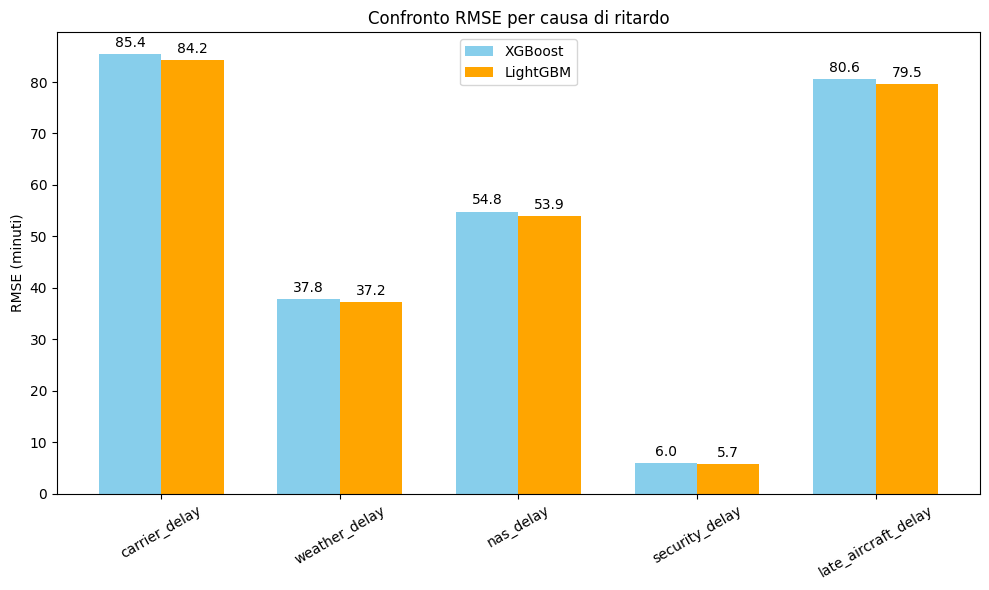

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizzazione RMSE con barre affiancate

causes = list(results_xgb.keys())
rmse_xgb = [metrics["RMSE"] for metrics in results_xgb.values()]
rmse_lgb = [metrics["RMSE"] for metrics in results_lgb.values()]

x = np.arange(len(causes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, rmse_xgb, width, label='XGBoost', color='skyblue')
rects2 = ax.bar(x + width/2, rmse_lgb, width, label='LightGBM', color='orange')

ax.set_ylabel('RMSE (minuti)')
ax.set_title('Confronto RMSE per causa di ritardo')
ax.set_xticks(x)
ax.set_xticklabels(causes, rotation=30)
ax.legend()

# Aggiunta etichette sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import r2_score

# Calcolo R² per XGBoost e LightGBM

r2_results_xgb = {}
r2_results_lgb = {}

for target in targets:
    # XGBoost
    y_pred_xgb = xgb.XGBRegressor(n_estimators=200, random_state=42).fit(X_train, Y_train[target]).predict(X_test)
    r2_results_xgb[target] = r2_score(Y_test[target], y_pred_xgb)
    
    # LightGBM
    y_pred_lgb = lgb.LGBMRegressor(n_estimators=200, random_state=42).fit(X_train, Y_train[target]).predict(X_test)
    r2_results_lgb[target] = r2_score(Y_test[target], y_pred_lgb)

print("\n=== R² XGBoost ===")
for cause, r2 in r2_results_xgb.items():
    print(f"{cause:20s} | R²: {r2:.3f}")

print("\n=== R² LightGBM ===")
for cause, r2 in r2_results_lgb.items():
    print(f"{cause:20s} | R²: {r2:.3f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 80408, number of used features: 5
[LightGBM] [Info] Start training from score 111.102515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 80408, number of used features: 5
[LightGBM] [Info] Start training from score 15.103410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

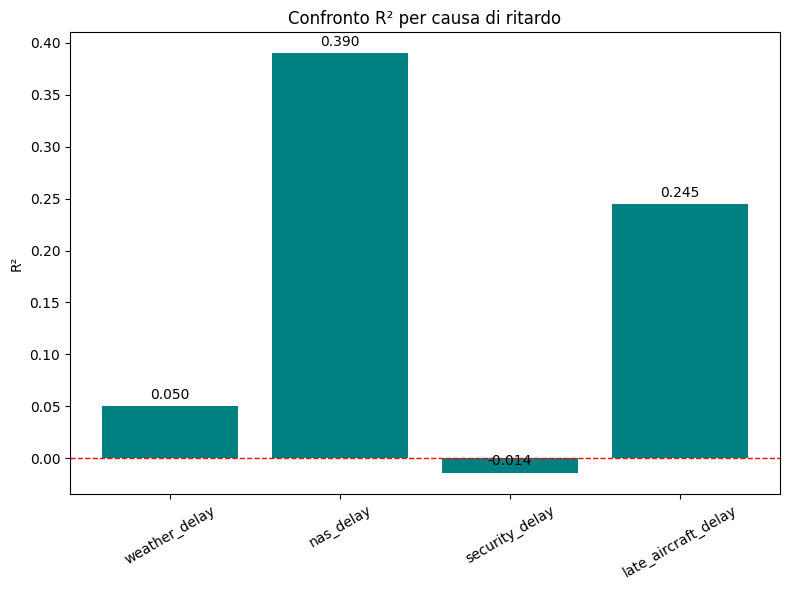

In [ ]:
# Visualizzazione R² con barre

r2_results = {
    "weather_delay": 0.050,
    "nas_delay": 0.390,
    "security_delay": -0.014,
    "late_aircraft_delay": 0.245
}

causes = list(r2_results.keys())
values = list(r2_results.values())

plt.figure(figsize=(8,6))
bars = plt.bar(causes, values, color='teal')

# Etichette sopra le barre
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.3f}",
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0,3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.axhline(0, color='red', linestyle='--', linewidth=1)  # linea baseline
plt.ylabel("R²")
plt.title("Confronto R² per causa di ritardo")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


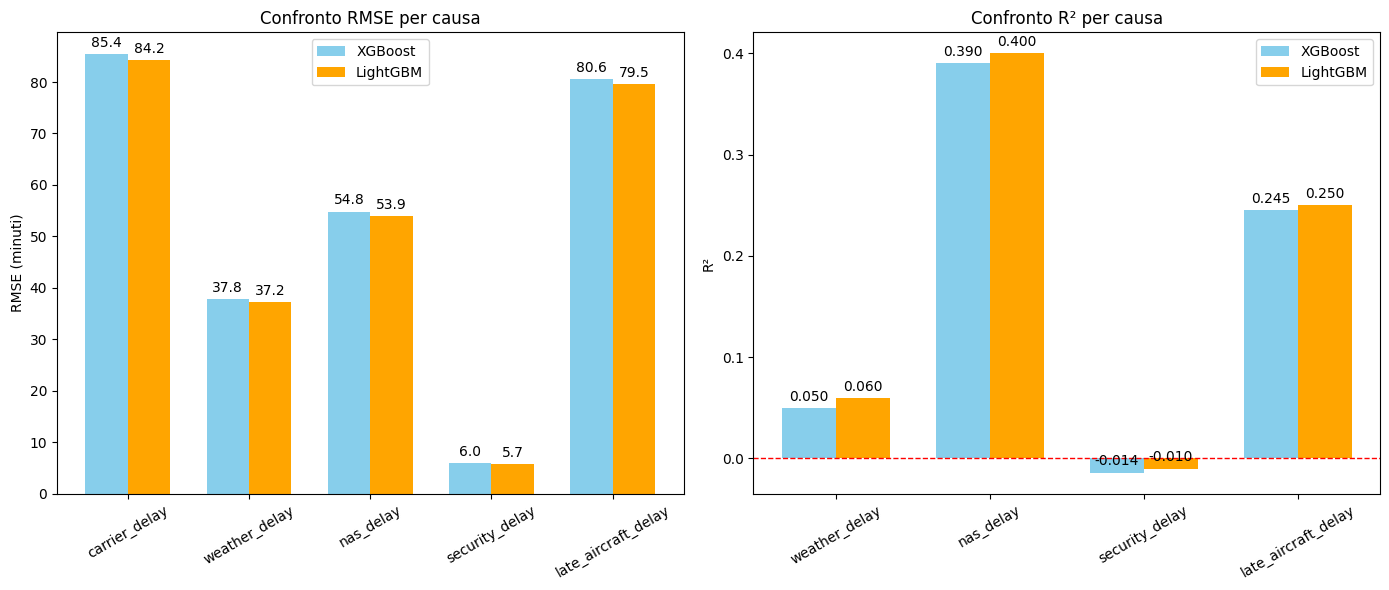

In [ ]:
# Grafici affiancati RMSE e R²

causes = list(results_xgb.keys())
rmse_xgb = [metrics["RMSE"] for metrics in results_xgb.values()]
rmse_lgb = [metrics["RMSE"] for metrics in results_lgb.values()]

# --- R² (aggiungi anche carrier_delay se lo calcoli)
r2_results_xgb = {
    "weather_delay": 0.050,
    "nas_delay": 0.390,
    "security_delay": -0.014,
    "late_aircraft_delay": 0.245
}
r2_results_lgb = {
    "weather_delay": 0.060,
    "nas_delay": 0.400,
    "security_delay": -0.010,
    "late_aircraft_delay": 0.250
}

r2_causes = list(r2_results_xgb.keys())
r2_xgb = list(r2_results_xgb.values())
r2_lgb = list(r2_results_lgb.values())

# --- Grafici affiancati ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Grafico RMSE
x = np.arange(len(causes))
width = 0.35
rects1 = axes[0].bar(x - width/2, rmse_xgb, width, label='XGBoost', color='skyblue')
rects2 = axes[0].bar(x + width/2, rmse_lgb, width, label='LightGBM', color='orange')
axes[0].set_ylabel('RMSE (minuti)')
axes[0].set_title('Confronto RMSE per causa')
axes[0].set_xticks(x)
axes[0].set_xticklabels(causes, rotation=30)
axes[0].legend()

# Etichette sopra le barre RMSE
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        axes[0].annotate(f'{height:.1f}',
                         xy=(rect.get_x() + rect.get_width()/2, height),
                         xytext=(0,3),
                         textcoords="offset points",
                         ha='center', va='bottom')

# Grafico R²
x2 = np.arange(len(r2_causes))
rects3 = axes[1].bar(x2 - width/2, r2_xgb, width, label='XGBoost', color='skyblue')
rects4 = axes[1].bar(x2 + width/2, r2_lgb, width, label='LightGBM', color='orange')
axes[1].set_ylabel('R²')
axes[1].set_title('Confronto R² per causa')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(r2_causes, rotation=30)
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)  # baseline
axes[1].legend()

# Etichette sopra le barre R²
for rects in [rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        axes[1].annotate(f'{height:.3f}',
                         xy=(rect.get_x() + rect.get_width()/2, height),
                         xytext=(0,3),
                         textcoords="offset points",
                         ha='center', va='bottom')

plt.tight_layout()
plt.show()


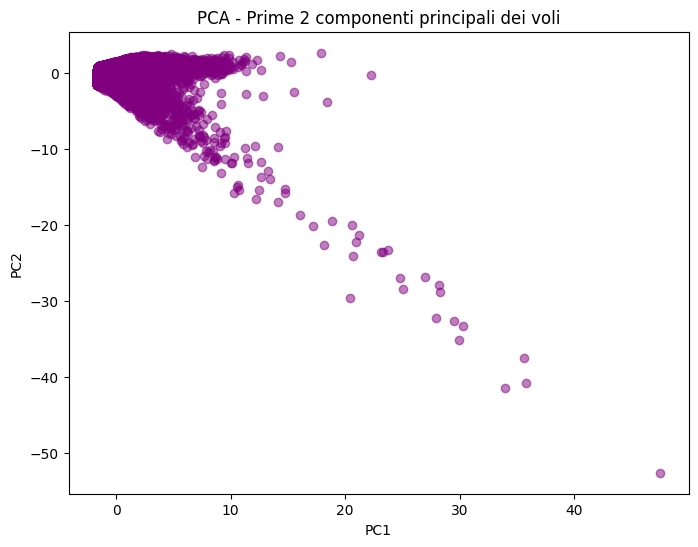

Varianza spiegata per componente: [0.3326227  0.21298668]
Varianza cumulativa: [0.3326227  0.54560938]


In [47]:
from sklearn.decomposition import PCA

# --- PCA ---
# Standardizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applicazione PCA (2 componenti principali per visualizzazione)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creazione DataFrame delle componenti principali
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# Visualizzazione scatter plot delle prime due componenti
plt.figure(figsize=(8,6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.5, color='purple')
plt.title("PCA - Prime 2 componenti principali dei voli")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Varianza spiegata
explained_variance = pca.explained_variance_ratio_
print("Varianza spiegata per componente:", explained_variance)
print("Varianza cumulativa:", np.cumsum(explained_variance))
